In [1]:
# Do the necessary imports
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, transpile, Aer, IBMQ
from qiskit import IBMQ, Aer, transpile, assemble, BasicAer
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.extensions import Initialize
from qiskit.ignis.verification import marginal_counts
from qiskit.quantum_info import random_statevector

provider = IBMQ.load_account()

In [2]:
#Generate a TGT using a quantum key that will serve as the KRBTGT password

def encrypt(qc, bitchain, qkey):
    for bit in range(0,len(bitchain)):
        if(bitchain[bit] == '1'):
            qc.x(bit)
        if(qkey[2*bit] == '1'):
            qc.z(bit)
        if(qkey[2*bit+1] == '1'):
            qc.x(bit)
    return qc

def decrypt(qc, cypherchain, qkey):
    for bit in range(0,cypherchain):
        if(qkey[2*bit] == '1'):
            qc.z(bit)
        if(qkey[2*bit+1] == '1'):
            qc.x(bit)
    return qc

def quantum_random_key(length,backend):
    qkey = ''
    for i in range(0,2*length):
        qc = QuantumCircuit(1,1)
        qc.h(0)
        qc.measure(0,0)
        counts = execute(qc, backend=backend, shots=1).result().get_counts(qc)
        qkey += list(counts.keys())[0]
    return qkey

def execute_circuit(qc,backend):
    job = execute(qc, backend, shots=100)
    result = job.result()
    return result.get_counts(qc)

The KRBTGT password used to sign all tickets is: 01
The TGT generated from DC is embedded in the following circuit


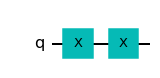

In [3]:
initialString = '1'
backend = BasicAer.get_backend('qasm_simulator')
qkey = quantum_random_key(len(initialString),backend)
print("The KRBTGT password used to sign all tickets is: " + qkey )
TGT_dc = QuantumCircuit(len(initialString), name = 'TGT granted')
encrypt(TGT_dc,initialString,qkey)
print ("The TGT generated from DC is embedded in the following circuit")
forged_TGT= TGT_dc.to_gate()
#krbtgt = qkey.to_gate()
TGT_dc.draw(output='mpl', filename='ransomware.png')

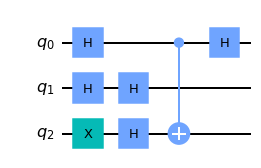

In [4]:
#This chunk refers to convert the qkey into a circuit and pack it into a gate, for representation in the golden ticket circuit 
#with the Server

krbtgt_circuit = QuantumCircuit(len(qkey)+1, name = 'KRBTGT account')

krbtgt_circuit.h(range(len(qkey)))
krbtgt_circuit.x(len(qkey))
krbtgt_circuit.h(len(qkey))



for  i,j in enumerate(reversed(qkey)):
    if j == '1':
       krbtgt_circuit.cx(i,len(qkey))



krbtgt_circuit.h(range(len(qkey)))


krbtgt_gate=krbtgt_circuit.to_gate()
krbtgt_circuit.draw(output='mpl', filename='krbtgt.png')

In [5]:
def golden_ticket( service_TGS, # service to be requested
                         backend='qasm_simulator', # backend to be used, default is set to 'qasm_simulator'
                         TGT=False, # If server grants TGT then User can initiate a connection to a service
                         attacker=False
                         ):
    
    # Get backend
    
    if backend == 'qasm_simulator':
        device = Aer.get_backend(backend) # use Aer if the backend is the 'qasm_simulator' (default)
    else:
        device = provider.get_backend(backend) # use the provider otherwise

    # Quantum circuit to simulate the communication process
    
    Alice = QuantumRegister(1,'alice@foo.com') # Alice's Quantum Register
    Server = QuantumRegister(3,'serverDC') # Server's Quantum Register
    ServiceA = QuantumRegister(1,'serviceA')
    ServiceB = QuantumRegister(1,'serviceB')
    Attacker = QuantumRegister(len(qkey)+1, 'attacker@foo.com')
    
    
    cr1 = ClassicalRegister(1,'measure_Alice') # classical registers 
    cr2 = ClassicalRegister(len(qkey),'measure_ServerDC')
    cr3 = ClassicalRegister(1,'measure_ServiceA')
    cr4 = ClassicalRegister(1,'measure_ServiceB')
    cr5 = ClassicalRegister(len(qkey),'measureAttacker')
    
    
    initialc = QuantumCircuit() # quantum circuit (initially empty)
    initialc.add_register(Alice) # add Alice's quantum register to the quantum circuit
    initialc.add_register(Server) # add Server's quantum register to the quantum circuit

    
    circuit= initialc.compose(krbtgt_gate,[1,2,3])
    circuit.barrier([Alice,Server]) 
  
       
   
    if service_TGS == 'A':
       
        
        if (attacker == True and TGT == True):
                circuit.add_register(Attacker)
                extraction = QuantumCircuit(name='QuantumDCSync')
                extraction.add_register(Server)
                extraction.add_register(Attacker)
                extraction.cx(Server,Attacker)
                extraction.cx(Attacker,Server)
                extraction.cx(Server,Attacker)
                extr_gate = extraction.to_gate()
                circuit = circuit.compose(extr_gate, [1,2,3,4,5,6])
                circuit.add_register(cr5)
                circuit.measure(Attacker[0:len(qkey)], cr5[0:len(qkey)])
                circuit = circuit.compose(forged_TGT, [0]) 
                circuit.x(Alice)
                circuit.add_register(ServiceA)                
                circuit.add_register(cr2)
                circuit.add_register(cr3)
                circuit.swap(Alice,ServiceA)
                circuit.measure(ServiceA, cr3)
                circuit.measure(Server[0:len(qkey)],cr2)
                
        if (attacker == False and TGT == True):
                circuit = circuit.compose(forged_TGT, [0]) 
                circuit.x(Alice) 
                circuit.add_register(ServiceA)                
                circuit.add_register(cr2)
                circuit.add_register(cr3)
                circuit.swap(Alice,ServiceA)
                circuit.measure(ServiceA, cr3)
                circuit.measure(Server[0:len(qkey)],cr2)
                    
        
    elif service_TGS == 'B':
        
        if (attacker == True and TGT == True):
                circuit.add_register(Attacker)
                extraction = QuantumCircuit(name='QuantumDCSync')
                extraction.add_register(Server)
                extraction.add_register(Attacker)
                extraction.cx(Server,Attacker)
                extraction.cx(Attacker,Server)
                extraction.cx(Server,Attacker)
                extr_gate = extraction.to_gate()
                circuit = circuit.compose(extr_gate, [1,2,3,4,5,6])              
                circuit.add_register(cr5)
                circuit.measure(Attacker[0:len(qkey)], cr5[0:len(qkey)])
                circuit = circuit.compose(forged_TGT, [0]) 
                circuit.y(Alice) 
                circuit.add_register(ServiceB)               
                circuit.add_register(cr2)
                circuit.add_register(cr4)
                circuit.swap(Alice,ServiceB)
                circuit.measure(ServiceB, cr4)
                circuit.measure(Server[0:len(qkey)],cr2)
                
        if (attacker == False and TGT == True):
                circuit = circuit.compose(forged_TGT, [0]) 
                circuit.y(Alice) 
                circuit.add_register(ServiceB)                
                circuit.add_register(cr2)
                circuit.add_register(cr4)
                circuit.swap(Alice,ServiceB)
                circuit.measure(ServiceB, cr4)
                circuit.measure(Server[0:len(qkey)],cr2)
                    
        
    circuit.barrier([Alice,Server])
   
    
    # The Python function returns the circuit and the device for simulation
    return circuit, device
    
def run_circuit(circuit,device,num_shots=1000):
    # Execute the circuit on the device for the number of shots defined
    job = execute(circuit, device, shots=num_shots)
    
    # Get the simulation results for the repeated experiments
    result = job.result()
    
    # Extract the counts, print them and return them for further processing
    counts = result.get_counts(circuit)
    print(counts)
    return counts


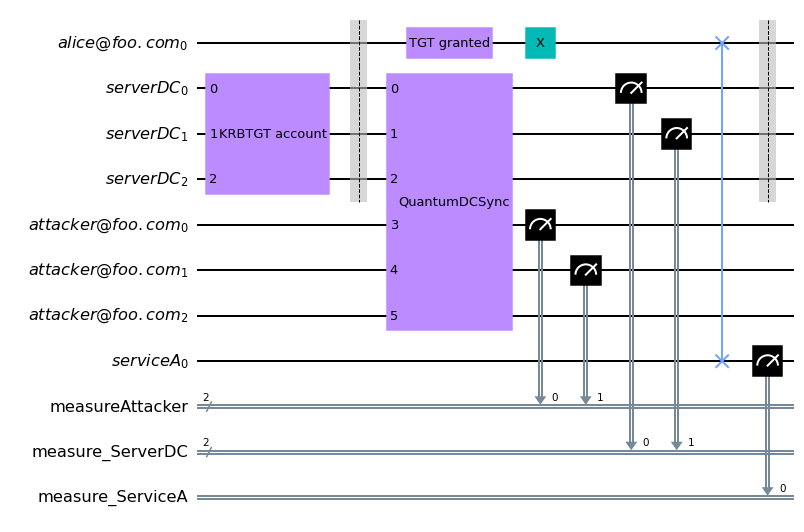

In [26]:
circuit, device = golden_ticket(service_TGS='A', TGT=True , attacker= True)
circuit.draw(output='mpl', filename='attacker.png')

{'1 00 01': 1000}


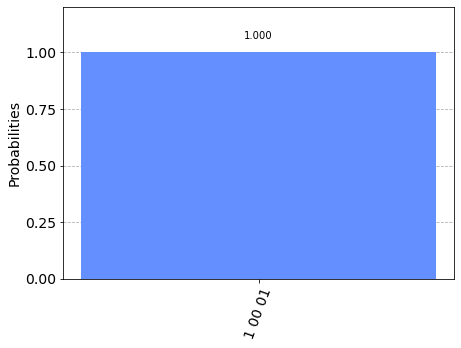

In [27]:
counts = run_circuit(circuit,device)
plot_histogram(counts)